# Training an FNO to approximate a dynamical system (TASK 3/4 all to all training)

In [1]:
import torch
import torch.nn as nn
import os
import numpy as np
from torch.utils.data import DataLoader, TensorDataset, Dataset
import torch.nn.functional as F
from torch.optim import Adam
import matplotlib.pyplot as plt


## Define 1D Fourier layer

In [2]:
class SpectralConv1d(nn.Module):
    def __init__(self, in_channels, out_channels, modes1):
        super(SpectralConv1d, self).__init__()

        """
        1D Fourier layer. It does FFT, linear transform, and Inverse FFT.
        """

        self.in_channels = in_channels
        self.out_channels = out_channels
        self.modes1 = modes1

        self.scale = (1 / (in_channels * out_channels))
        self.weights1 = nn.Parameter(self.scale * torch.rand(in_channels, out_channels, self.modes1, dtype=torch.cfloat))
        self.activation = nn.Tanh()

    # Complex multiplication
    def compl_mul1d(self, input, weights):
        return torch.einsum("bix,iox->box", input, weights)

    def forward(self, x):
        batchsize = x.shape[0]

        # Compute Fourier coefficients
        x_ft = torch.fft.rfft(x)

        # Multiply relevant Fourier modes
        out_ft = torch.zeros(batchsize, self.out_channels, x.size(-1) // 2 + 1, device=x.device, dtype=torch.cfloat)
        out_ft[:, :, :self.modes1] = self.compl_mul1d(x_ft[:, :, :self.modes1], self.weights1)

        # Return to physical space
        x = torch.fft.irfft(out_ft, n=x.size(-1))
        return x


## Define Time conditional normalization layer

In [3]:
#---------------------
# Time-conditional BN:
#---------------------

class FILM(torch.nn.Module):
    def __init__(self, channels, use_bn=True):
        super(FILM, self).__init__()
        self.channels = channels

        self.inp2scale = nn.Linear(in_features=1, out_features=channels, bias=True)
        self.inp2bias = nn.Linear(in_features=1, out_features=channels, bias=True)

        self.inp2scale.weight.data.fill_(0)
        self.inp2scale.bias.data.fill_(0)
        self.inp2bias.weight.data.fill_(0)
        self.inp2bias.bias.data.fill_(0)

        if use_bn:
            self.norm = nn.BatchNorm1d(channels)
        else:
            self.norm = nn.Identity()

    def forward(self, x, time):

        x = self.norm(x)
        time = time.reshape(-1, 1).type_as(x)
        scale = self.inp2scale(time)
        bias = self.inp2bias(time)
        scale = scale.unsqueeze(2).expand_as(x)
        bias = bias.unsqueeze(2).expand_as(x)

        return x * (1. + scale) + bias


## Build 1D FNO (one to one mapping)

In [4]:
class FNO1d(nn.Module):
    def __init__(self, modes, width):
        super(FNO1d, self).__init__()

        """
        4 Fourier layer.
        1. Lift the input to the desire channel dimension by self.fc0
        2. 4 layers of the integral operators u' = (W + K)(u).
            W defined by self.w; K defined by self.conv .
        3. Project from the channel space to the output space by self.fc1 and self.fc2 .

        input: the solution of the initial condition and location (a(x), x)
        input shape: (batchsize, x=s, c=2)
        output: the solution of a later timestep
        output shape: (batchsize, x=s, c=1)
        """

        self.modes1 = modes
        self.width = width
        self.linear_p = nn.Linear(2, self.width)

        self.spect1 = SpectralConv1d(self.width, self.width, self.modes1)
        self.spect2 = SpectralConv1d(self.width, self.width, self.modes1)
        self.spect3 = SpectralConv1d(self.width, self.width, self.modes1)
        self.lin0 = nn.Conv1d(self.width, self.width, 1)
        self.lin1 = nn.Conv1d(self.width, self.width, 1)
        self.lin2 = nn.Conv1d(self.width, self.width, 1)

        self.norm1 = FILM(self.width, use_bn=False)
        self.norm2 = FILM(self.width, use_bn=False)
        self.norm3 = FILM(self.width, use_bn=False)

        self.linear_q = nn.Linear(self.width, 32)
        self.output_layer = nn.Linear(32, 1)

        self.activation = torch.nn.Tanh()

    def fourier_layer(self, x, t_, spectral_layer, conv_layer, norm):
        x_out = spectral_layer(x) + conv_layer(x)
        x_out = norm(x_out, t_)
        return self.activation(x_out)

    def linear_layer(self, x, linear_transformation):
        return self.activation(linear_transformation(x))

    def forward(self, x, t_):
        x = self.linear_p(x)
        x = x.permute(0, 2, 1)

        x = self.fourier_layer(x, t_, self.spect1, self.lin0, self.norm1)
        x = self.fourier_layer(x, t_, self.spect2, self.lin1, self.norm2)
        x = self.fourier_layer(x, t_, self.spect3, self.lin2, self.norm3)

        x = x.permute(0, 2, 1)

        x = self.linear_layer(x, self.linear_q)
        x = self.output_layer(x)
        return x


In [5]:
torch.manual_seed(0)
np.random.seed(0)

In [6]:
class PDEDataset(Dataset):
    def __init__(self,
                 which="training",
                 training_samples = 1024,
                 resolution = 128):

        self.resolution = resolution

        if which == "training":
            self.data = np.load("Data/data_train_128.npy")
            if training_samples is not None:
                self.data = self.data[:training_samples]
        elif which == "validation":
            self.data = np.load("Data/data_val_128.npy")
        else:
            self.data = np.load("Data/data_test_128.npy")

        self.T = 5

        # Precompute all possible (t_initial, t_final) pairs within the specified range.
        self.time_pairs = [(i, j) for i in range(0, self.T) for j in range(i + 1, self.T)]
        self.len_times  = len(self.time_pairs)

        self.length = self.data.shape[0] * self.len_times

        self.mean = np.mean(self.data)
        self.std  = np.std(self.data)

    def __len__(self):
        return self.length

    def __getitem__(self, index):

        sample_idx = index // self.len_times
        time_pair_idx = index % self.len_times
        t_inp, t_out = self.time_pairs[time_pair_idx]
        dt = (t_out - t_inp) / 4.0
        time_val = dt + float(np.random.rand(1)[0]/10**6) # add noise for stability

        inputs = torch.from_numpy(self.data[sample_idx, t_inp]).type(torch.float32).reshape(1, 128)
        inputs = (inputs - self.mean)/self.std #Normalize
        inputs_t = torch.ones(1, 128).type(torch.float32) * time_val
        inputs = torch.cat((inputs, inputs_t), 0) #Cat time to the input

        outputs = torch.from_numpy(self.data[sample_idx, t_out]).type(torch.float32).reshape(1, 128)
        outputs = (outputs - self.mean)/self.std #Normalize

        return time_val, inputs, outputs

In [7]:
# Configuration
n_train = 1024
batch_size = 32
learning_rate = 0.001
epochs = 50
step_size = 10
gamma = 0.5

# Initialize Loaders
training_set = DataLoader(PDEDataset("training", training_samples=n_train), batch_size=batch_size, shuffle=True)
validation_set = DataLoader(PDEDataset("validation"), batch_size=batch_size, shuffle=False)

In [27]:
for step, (time_batch, input_batch, output_batch) in enumerate(training_set):
    print(step)
    pass

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [8]:
modes = 16
width = 128

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
fno = FNO1d(modes, width).to(device) # model


## Training

In [9]:
def calculate_relative_l2(pred, true):
    diff_norm = torch.norm(pred - true, p=2, dim=1)

    true_norm = torch.norm(true, p=2, dim=1)

    loss = torch.mean(diff_norm / true_norm) # = 1/128 * sum

    return loss.item()

In [10]:

optimizer = Adam(fno.parameters(), lr=learning_rate, weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)

l = nn.MSELoss()
freq_print = 1

train_loss_history = []
val_loss_history = []

for epoch in range(epochs):
    train_mse = 0.0
    for step, (time_batch, input_batch, output_batch) in enumerate(training_set):
        optimizer.zero_grad()
        input_batch = input_batch.permute(0, 2, 1).to(device)
        output_batch = output_batch.squeeze(1).to(device)

        output_pred_batch = fno(input_batch, time_batch).squeeze(2)

        loss = l(output_pred_batch, output_batch)
        loss.backward()
        optimizer.step()
        train_mse += loss.item()
    train_mse /= len(training_set)

    scheduler.step()

    fno.eval()
    val_relative_l2 = 0.0
    with torch.no_grad():
        for step, (time_batch, input_batch, output_batch) in enumerate(validation_set):
            input_batch = input_batch.permute(0, 2, 1).to(device)
            output_batch = output_batch.squeeze(1).to(device)
            output_pred_batch = fno(input_batch, time_batch).squeeze(2)

            loss_f = calculate_relative_l2(output_pred_batch, output_batch)
            val_relative_l2 += loss_f
        val_relative_l2 /= len(validation_set)

    val_loss_history.append(val_relative_l2)
    train_loss_history.append(train_mse)

    if epoch % freq_print == 0: print("######### Epoch:", epoch, " ######### Train Loss:", train_mse, " ######### Relative L2 Val Norm:", val_relative_l2)



######### Epoch: 0  ######### Train Loss: 0.023798201743920798  ######### Relative L2 Val Norm: 0.09305259473621845
######### Epoch: 1  ######### Train Loss: 0.003661577352977474  ######### Relative L2 Val Norm: 0.07632932029664516
######### Epoch: 2  ######### Train Loss: 0.0024818278770908364  ######### Relative L2 Val Norm: 0.07604395411908627
######### Epoch: 3  ######### Train Loss: 0.0025107464478423937  ######### Relative L2 Val Norm: 0.08289324305951595
######### Epoch: 4  ######### Train Loss: 0.002329449087665125  ######### Relative L2 Val Norm: 0.06868232265114785
######### Epoch: 5  ######### Train Loss: 0.002032316604345397  ######### Relative L2 Val Norm: 0.074008709192276
######### Epoch: 6  ######### Train Loss: 0.0011244701204304874  ######### Relative L2 Val Norm: 0.06710228510200977
######### Epoch: 7  ######### Train Loss: 0.006703691873281059  ######### Relative L2 Val Norm: 0.18245264366269112
######### Epoch: 8  ######### Train Loss: 0.0015780475565406959  ######

In [16]:
save_path = os.path.join("model_storage", f"all_to_all_model.pt")
torch.save({
    "model_state_dict": fno.state_dict(),
    "val_loss_history": val_loss_history,
    "train_loss_history": train_loss_history,
    "modes": modes,
    "width": width,
    "optimizer_state_dict": optimizer.state_dict(),
    "train_mean": training_set.dataset.mean,
    "train_std": training_set.dataset.std,
}, save_path)

### Plotting val and train error

Loaded model from model_storage\all_to_all_model.pt
Training epochs recorded: 50


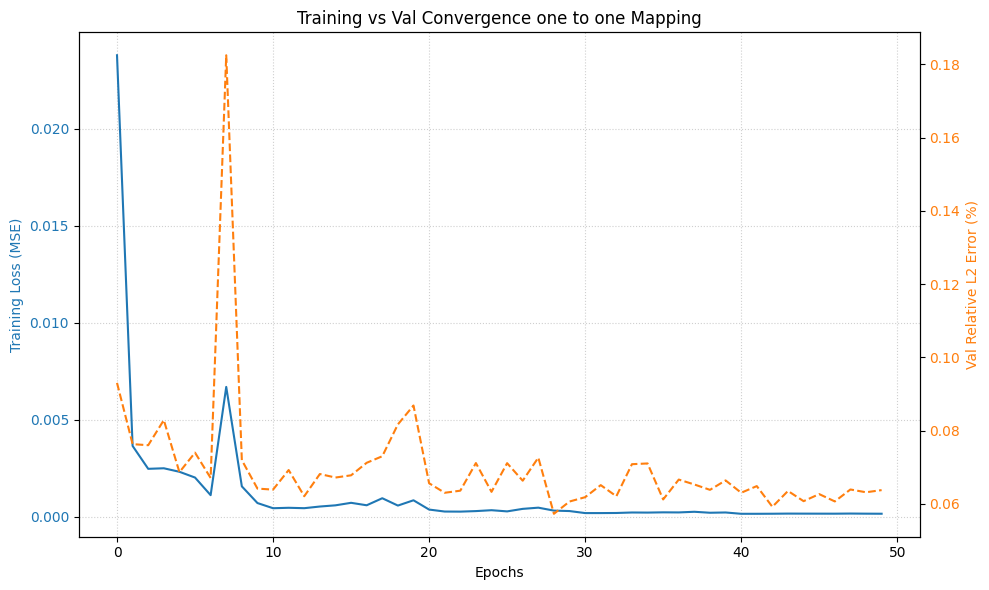

In [18]:
load_path = os.path.join("model_storage", f"all_to_all_model.pt")

checkpoint = torch.load(load_path, weights_only=False)
train_history = checkpoint["train_loss_history"]
val_history = checkpoint["val_loss_history"]
print(f"Loaded model from {load_path}")
print(f"Training epochs recorded: {len(train_history)}")

fig, ax1 = plt.subplots(figsize=(10, 6))

color = 'tab:blue'
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Training Loss (MSE)', color=color)
ax1.plot(train_history, color=color, label='Train MSE')
ax1.tick_params(axis='y', labelcolor=color)
ax1.grid(True, which='both', linestyle=':', alpha=0.6)

ax2 = ax1.twinx()
color = 'tab:orange'
ax2.set_ylabel('Val Relative L2 Error (%)', color=color)
ax2.plot(val_history, color=color, linestyle='--', label='Val Rel L2')
ax2.tick_params(axis='y', labelcolor=color)

plt.title(f"Training vs Val Convergence one to one Mapping")
fig.tight_layout()  # Adjust layout to prevent clipping of labels
plt.show()

## Task 3a / 3b Testing (we solve u0 -> time since we want to compare it to Task 1 where we had u0 -> 1)

Task 3a Result:
Average Relative L2 Error at t=1.0: 4.2357
Task 3b Results (Error over Time):
Time t=0.25 | Relative L2 Error: 1.6841%
Time t=0.50 | Relative L2 Error: 2.4019%
Time t=0.75 | Relative L2 Error: 3.1389%
Time t=1.00 | Relative L2 Error: 4.2357%


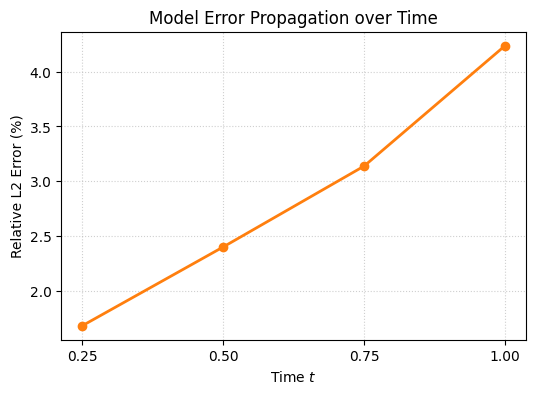

In [28]:
# Define paths
model_path = os.path.join("model_storage", "all_to_all_model.pt")
data_path = "Data/data_test_128.npy"

checkpoint = torch.load(model_path, weights_only=False)
modes = checkpoint.get("modes", 16)
width = checkpoint.get("width", 64)

train_mean = checkpoint.get("train_mean", np.mean)
train_std = checkpoint.get("train_std", np.std)

# Instantiate Model
fno_eval = FNO1d(modes, width)
fno_eval.load_state_dict(checkpoint["model_state_dict"])
fno_eval.eval()

data_test = np.load(data_path)
data_test = torch.from_numpy(data_test).float()

num_test = data_test.shape[0]     # 128
spatial_dim = data_test.shape[2]  # 128

def evaluate_at_timestep(model, t_val, t_idx):
    """
    Evaluates the model for a specific time t_val against the ground truth at index t_idx.
    """
    model.eval()
    with torch.no_grad():
        u0 = data_test[:, 0, :]
        u0_norm = (u0 - train_mean) / train_std # normalize

        t_channel = torch.full((num_test, spatial_dim), t_val)
        x_input = torch.stack([u0_norm, t_channel], dim=-1)

        t_scalar = torch.full((num_test, 1), t_val)

        u_pred_norm = model(x_input, t_scalar).squeeze(2)
        u_pred = (u_pred_norm * train_std) + train_mean # denormalize

        u_true = data_test[:, t_idx, :]

        diff_norm = torch.norm(u_pred - u_true, p=2, dim=1)
        true_norm = torch.norm(u_true, p=2, dim=1)

        avg_rel_err = torch.mean(diff_norm / true_norm).item() * 100

        return avg_rel_err

# Task 3a Evaluate at t = 1.0
# t=1.0 corresponds to index 4 in the dataset
error_t1 = evaluate_at_timestep(fno_eval, t_val=1.0, t_idx=4)

print(f"Task 3a Result:")
print(f"Average Relative L2 Error at t=1.0: {error_t1:.4f}")

# Task 3b: Evaluate at Multiple Time Steps
# Time steps: 0.25 (idx 1), 0.50 (idx 2), 0.75 (idx 3), 1.0 (idx 4)
time_steps = [0.25, 0.50, 0.75, 1.0]
indices = [1, 2, 3, 4]
errors = []

print(f"Task 3b Results (Error over Time):")
for t, idx in zip(time_steps, indices):
    err = evaluate_at_timestep(fno_eval, t_val=t, t_idx=idx)
    errors.append(err)
    print(f"Time t={t:.2f} | Relative L2 Error: {err:.4f}%")

plt.figure(figsize=(6, 4))
plt.plot(time_steps, errors, marker='o', linestyle='-', color='tab:orange', linewidth=2)
plt.xlabel("Time $t$")
plt.ylabel("Relative L2 Error (%)")
plt.title("Model Error Propagation over Time")
plt.grid(True, linestyle=":", alpha=0.6)
plt.xticks(time_steps)
plt.show()

## Task 4 Finetuning

### Taks 4a (test on dataset drawn from an unknown distribution data test unknown 128.npy)

In [33]:
path_unknown = "Data/data_test_unknown_128.npy"
data_test = np.load(path_unknown)
data_test = torch.from_numpy(data_test).float()

print(f"Loaded Unknown Distribution Data: {data_test.shape}")

# Update shape constants just in case
num_test = data_test.shape[0]
spatial_dim = data_test.shape[2]

# Evaluate at t = 1.0
error_unknown = evaluate_at_timestep(fno_eval, t_val=1.0, t_idx=4)

print(f"Task 4 Results (Zero-Shot / Unknown Distribution):")
print(f"Average Relative L2 Error at t=1.0: {error_unknown:.4f}%")

Loaded Unknown Distribution Data: torch.Size([128, 5, 128])
Task 4 Results (Zero-Shot / Unknown Distribution):
Average Relative L2 Error at t=1.0: 15.4626%


### Task 4b Use 32 trajectories from data finetune train unknown 128.npy to finetune the model trained in Task 3

In [34]:
class FinetuneDataset(Dataset):
    def __init__(self,
                 which="training",
                 training_samples = 1024,
                 resolution = 128):

        self.resolution = resolution

        if which == "training":
            self.data = np.load("Data/data_finetune_train_unknown_128.npy")
            if training_samples is not None:
                self.data = self.data[:training_samples]
        elif which == "validation":
            self.data = np.load("Data/data_finetune_val_unknown_128.npy")
        else:
            self.data = np.load("Data/data_test_unknown_128.npy")

        self.T = 5

        # Precompute all possible (t_initial, t_final) pairs within the specified range.
        self.time_pairs = [(i, j) for i in range(0, self.T) for j in range(i + 1, self.T)]
        self.len_times  = len(self.time_pairs)

        self.length = self.data.shape[0] * self.len_times

        self.mean = np.mean(self.data)
        self.std  = np.std(self.data)

    def __len__(self):
        return self.length

    def __getitem__(self, index):

        sample_idx = index // self.len_times
        time_pair_idx = index % self.len_times
        t_inp, t_out = self.time_pairs[time_pair_idx]
        dt = (t_out - t_inp) / 4.0
        time_val = dt + float(np.random.rand(1)[0]/10**6) # add noise for stability

        inputs = torch.from_numpy(self.data[sample_idx, t_inp]).type(torch.float32).reshape(1, 128)
        inputs = (inputs - self.mean)/self.std #Normalize
        inputs_t = torch.ones(1, 128).type(torch.float32) * time_val
        inputs = torch.cat((inputs, inputs_t), 0) #Cat time to the input

        outputs = torch.from_numpy(self.data[sample_idx, t_out]).type(torch.float32).reshape(1, 128)
        outputs = (outputs - self.mean)/self.std #Normalize

        return time_val, inputs, outputs

In [37]:
# Setup Finetuning
# Load the PRE-TRAINED model from Task 3
model_path = os.path.join("model_storage", "all_to_all_model.pt")
checkpoint = torch.load(model_path, weights_only=False)

modes = checkpoint['modes']
width = checkpoint['width']

fno_finetune = FNO1d(modes=modes, width=width).to(device)
fno_finetune.load_state_dict(checkpoint["model_state_dict"])

# Data Loaders
# Small batchsize because we only have 32 samples
ft_train_loader = DataLoader(FinetuneDataset("train"), batch_size=8, shuffle=True)
ft_val_loader   = DataLoader(FinetuneDataset("val"), batch_size=8, shuffle=False)


In [39]:
# Optimizer with LOWER learning rate for finetuning
optimizer_ft = Adam(fno_finetune.parameters(), lr=1e-4, weight_decay=1e-5)
criterion = nn.MSELoss()
train_loss_history_ft = []
val_loss_history_ft = []
# Training Loop
epochs_ft = 50
for epoch in range(epochs_ft):
    fno_finetune.train()
    train_loss = 0.0

    for time_batch, x_batch, y_batch in ft_train_loader:
        optimizer_ft.zero_grad()

        # Prepare Data
        t_scalar = time_batch.float().unsqueeze(1).to(device)
        x_batch = x_batch.permute(0, 2, 1).to(device)
        y_batch = y_batch.squeeze(1).to(device)

        # Forward
        out = fno_finetune(x_batch, t_scalar).squeeze(2)
        loss = criterion(out, y_batch)

        loss.backward()
        optimizer_ft.step()
        train_loss += loss.item()

    # Calculate average training loss for this epoch
    avg_train_loss = train_loss / len(ft_train_loader)
    train_loss_history_ft.append(avg_train_loss)

    fno_finetune.eval()
    val_loss = 0.0
    with torch.no_grad():
        for time_batch, x_batch, y_batch in ft_val_loader:
            # Prepare Data (Same as train)
            t_scalar = time_batch.float().unsqueeze(1).to(device)
            x_batch = x_batch.permute(0, 2, 1).to(device)
            y_batch = y_batch.squeeze(1).to(device)

            out = fno_finetune(x_batch, t_scalar).squeeze(2)
            loss = criterion(out, y_batch)

            val_loss += loss.item()

    # Calculate average validation loss
    avg_val_loss = val_loss / len(ft_val_loader)
    val_loss_history_ft.append(avg_val_loss)

    if epoch % 10 == 0:
        print(f"FT Epoch {epoch} | Loss: {train_loss / len(ft_train_loader):.6f}")

FT Epoch 0 | Loss: 0.000720
FT Epoch 10 | Loss: 0.000611
FT Epoch 20 | Loss: 0.000663
FT Epoch 30 | Loss: 0.000607
FT Epoch 40 | Loss: 0.000508


In [40]:
save_path = os.path.join("model_storage", f"all_to_all_finetuned_model.pt")
torch.save({
    "model_state_dict": fno_finetune.state_dict(),
    "val_loss_history": val_loss_history_ft,
    "train_loss_history": train_loss_history_ft,
    "modes": modes,
    "width": width,
    "optimizer_state_dict": optimizer_ft.state_dict(),
    "train_mean": FinetuneDataset("train").mean,
    "train_std": FinetuneDataset("train").std,
}, save_path)

In [41]:
ft_ds = ft_train_loader.dataset
finetune_mean = ft_ds.mean
finetune_std = ft_ds.std

# Load Unknown Test Data
data_test_unknown = np.load("Data/data_test_unknown_128.npy")
data_test_unknown = torch.from_numpy(data_test_unknown).float()
num_test = data_test_unknown.shape[0]

# Evaluation Function (Adapted for Finetune Stats)
def evaluate_finetuned(model, t_val=1.0, t_idx=4):
    model.eval()
    with torch.no_grad():
        u0 = data_test_unknown[:, 0, :]
        u_true = data_test_unknown[:, t_idx, :]

        # Normalize inputs using FINETUNE stats
        u0_norm = (u0 - finetune_mean) / finetune_std
        t_channel = torch.full((num_test, 128), t_val)

        x_in = torch.stack([u0_norm, t_channel], dim=-1).to(device)
        t_scalar = torch.full((num_test, 1), t_val).to(device)

        # Predict
        u_pred_norm = model(x_in, t_scalar).squeeze(2).cpu()

        # Denormalize outputs using FINETUNE stats
        u_pred = (u_pred_norm * finetune_std) + finetune_mean

        # Error
        diff = torch.norm(u_pred - u_true, p=2, dim=1)
        true = torch.norm(u_true, p=2, dim=1)
        return torch.mean(diff / true).item() * 100

error_ft = evaluate_finetuned(fno_finetune)

print(f"Task 4b Result (Finetuned):")
print(f"Average Relative L2 Error: {error_ft:.4f}%")

Task 4b Result (Finetuned):
Average Relative L2 Error: 3.7840%


### Task 4c train new model from scratch all to all using the 32 unknown traj

In [42]:
# Setup model on finetuning data
fno_model_on_finetune_data = FNO1d(modes=modes, width=width).to(device)

# Data Loaders
# Small batchsize because we only have 32 samples
ft_train_loader = DataLoader(FinetuneDataset("train"), batch_size=8, shuffle=True)
ft_val_loader   = DataLoader(FinetuneDataset("val"), batch_size=8, shuffle=False)

In [43]:
# Optimizer with LOWER learning rate for finetuning
optimizer_new_ft = Adam(fno_model_on_finetune_data.parameters(), lr=1e-4, weight_decay=1e-5)
criterion = nn.MSELoss()
train_loss_history_fno_model_on_finetune_data = []
val_loss_history_fno_model_on_finetune_data = []
# Training Loop
epochs_ft = 50
for epoch in range(epochs_ft):
    fno_model_on_finetune_data.train()
    train_loss = 0.0

    for time_batch, x_batch, y_batch in ft_train_loader:
        optimizer_ft.zero_grad()

        # Prepare Data
        t_scalar = time_batch.float().unsqueeze(1).to(device)
        x_batch = x_batch.permute(0, 2, 1).to(device)
        y_batch = y_batch.squeeze(1).to(device)

        # Forward
        out = fno_model_on_finetune_data(x_batch, t_scalar).squeeze(2)
        loss = criterion(out, y_batch)

        loss.backward()
        optimizer_ft.step()
        train_loss += loss.item()

    # Calculate average training loss for this epoch
    avg_train_loss = train_loss / len(ft_train_loader)
    train_loss_history_fno_model_on_finetune_data.append(avg_train_loss)

    fno_model_on_finetune_data.eval()
    val_loss = 0.0
    with torch.no_grad():
        for time_batch, x_batch, y_batch in ft_val_loader:
            # Prepare Data (Same as train)
            t_scalar = time_batch.float().unsqueeze(1).to(device)
            x_batch = x_batch.permute(0, 2, 1).to(device)
            y_batch = y_batch.squeeze(1).to(device)

            out = fno_model_on_finetune_data(x_batch, t_scalar).squeeze(2)
            loss = criterion(out, y_batch)

            val_loss += loss.item()

    # Calculate average validation loss
    avg_val_loss = val_loss / len(ft_val_loader)
    val_loss_history_fno_model_on_finetune_data.append(avg_val_loss)

    if epoch % 10 == 0:
        print(f"FT Epoch {epoch} | Loss: {train_loss / len(ft_train_loader):.6f}")

FT Epoch 0 | Loss: 0.880742
FT Epoch 10 | Loss: 0.880742
FT Epoch 20 | Loss: 0.880742
FT Epoch 30 | Loss: 0.880743
FT Epoch 40 | Loss: 0.880742


In [44]:
save_path = os.path.join("model_storage", f"all_to_all_model_on_finetuned_data.pt")
torch.save({
    "model_state_dict": fno_finetune.state_dict(),
    "val_loss_history": val_loss_history_ft,
    "train_loss_history": train_loss_history_ft,
    "modes": modes,
    "width": width,
    "optimizer_state_dict": optimizer_ft.state_dict(),
    "train_mean": FinetuneDataset("train").mean,
    "train_std": FinetuneDataset("train").std,
}, save_path)

In [46]:
ft_ds = ft_train_loader.dataset
finetune_mean = ft_ds.mean
finetune_std = ft_ds.std

error_ft = evaluate_finetuned(fno_model_on_finetune_data)

print(f"Task 4c Result model on only finetuning data:")
print(f"Average Relative L2 Error: {error_ft:.4f}%")

Task 4c Result model on only finetuning data:
Average Relative L2 Error: 101.6486%
